In [1]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy


In [2]:
import warnings
import torchvision.models as models
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad=False
warnings.filterwarnings('ignore')

d:\Paper-Implementation\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Paper-Implementation\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = vgg.to(device)

In [4]:
content_layers = ['conv4_2']  # captures object structure
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']  # captures texture

content_layers = ['21']
style_layers = ['0', '5', '10', '19', '28'] 

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),    
    transforms.ToTensor(),            
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [6]:
def load_image(path):
    image = Image.open(path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image.to(device)


In [7]:
def imshow(tensor, ax):
    image = tensor.clone().detach().cpu().squeeze(0)
    image = image * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    image = image.clamp(0, 1)
    if ax!=0:
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
    else:
        image = image.permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.axis('off')  # Hide axes
        plt.show()

        

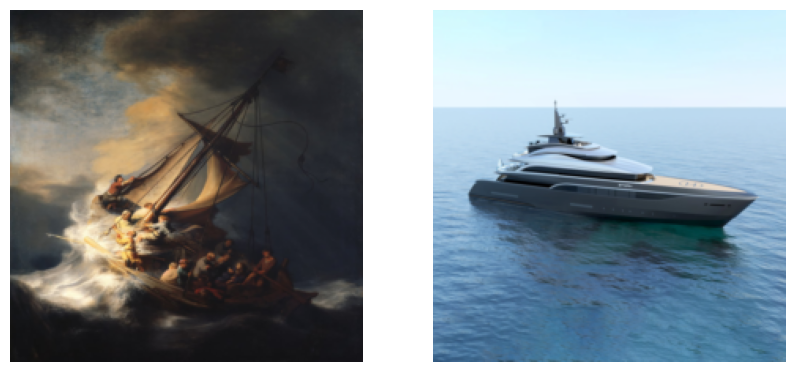

In [8]:
style_img = load_image("image2.png")
content_img = load_image("target2.png")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Display images on respective axes
imshow(style_img, ax1)
imshow(content_img, ax2)

generated_img = torch.randn_like(content_img).clamp(0, 1).requires_grad_(True)

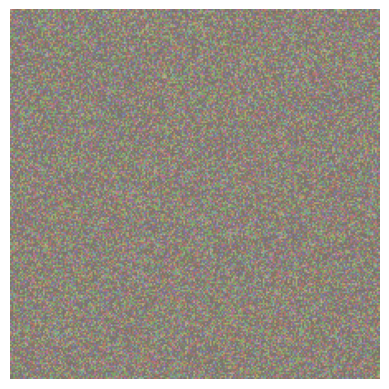

In [9]:
imshow(generated_img,0)

In [10]:
def get_features(x, model, layers):
    features = {}
    for name, layer in model._modules.items():
        x = layer(x) # We are just passing the image thorugh all layer in the CNN ONCE
        if name in layers:
            features[name] = x # if we encounter the requied layers [which we got from the paper], we just save the infromation of the feature maps obtained from these layers
    return features

In [11]:
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram / (c * h * w)

In [12]:
# Get feature mapsd
content_features = get_features(content_img, vgg, content_layers)
style_features = get_features(style_img, vgg, style_layers)

# Compute Gram
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


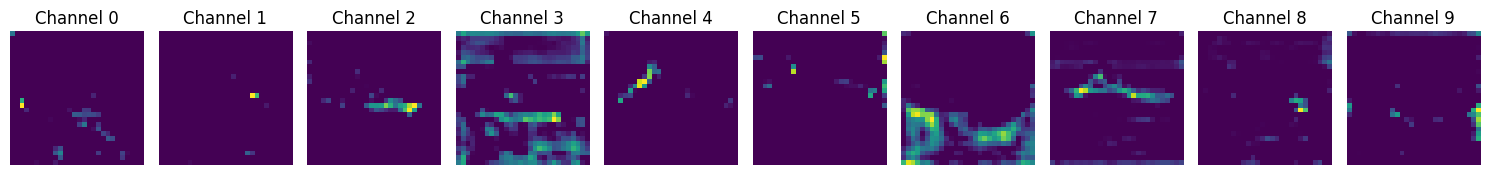

In [13]:
feature_map = content_features["21"].squeeze(0)  # shape becomes (512, 28, 28)

num_channels_to_show = 10
fig, axes = plt.subplots(1, num_channels_to_show, figsize=(15, 5))

for i in range(num_channels_to_show):
    ax = axes[i]
    channel = feature_map[i].detach().cpu().numpy()
    ax.imshow(channel, cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Channel {i}')

plt.tight_layout()
plt.show()

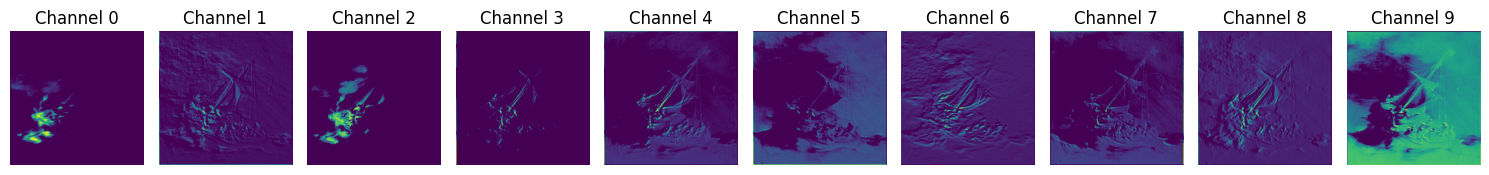

In [14]:
feature_map = style_features["0"].squeeze(0)

num_channels_to_show = 10
fig, axes = plt.subplots(1, num_channels_to_show, figsize=(15, 5))

for i in range(num_channels_to_show):
    ax = axes[i]
    channel = feature_map[i].detach().cpu().numpy()
    ax.imshow(channel, cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Channel {i}')

plt.tight_layout()
plt.show()

In [15]:
from IPython.display import clear_output, display
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
optimizer = torch.optim.Adam([generated_img], lr=0.1)
steps = 10000
# Weights for each style layer
style_weights = {'0': 1.0, '5': 0.75, '10': 0.5, '19': 0.25, '28': 0.1}
content_weight = 1000
style_weight = 10000

Step 10, Total Loss: 436.1284


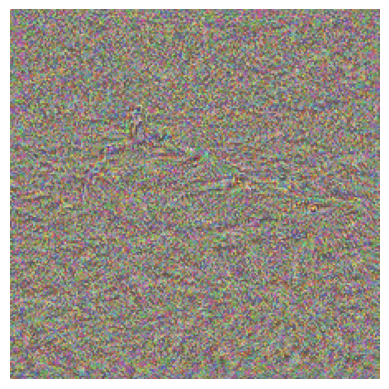

In [ ]:
for step in range(steps):
    # Get all the features at once, style wala pani, content wala pani
    generated_features = get_features(generated_img, vgg, style_layers + content_layers)

    # Content loss
    content_loss = torch.mean((generated_features['21'] - content_features['21']) ** 2) # Copying as it is from paper

    # Style loss
    style_loss = 0
    for layer in style_layers:
        gen_feat = generated_features[layer]
        gen_gram = gram_matrix(gen_feat)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((gen_gram - style_gram) ** 2)
        style_loss += layer_style_loss

    total_loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 10 == 0:
        print(f"Step {step}, Total Loss: {total_loss.item():.4f}")
        imshow(generated_img,0)
        clear_output(wait=True)
    
    if step%2000 ==0:
        content_weight /= 10
        style_weight *=10
